In [1]:
from train import get_grnti1_2_BERT_dataframes, get_grnti1_BERT_dataframes, prepair_datasets,\
prepair_model, prepair_compute_metrics, save_parameters, CustomTrainer, test_predictons,\
prepair_test_dataset, get_grnti1_BERT_dataframes
from peft import PeftConfig, PeftModel

from prediction import prepair_data_level2
from prediction import prepair_model as prepair_model_test
from prediction import prepair_dataset, make_predictions
from transformers import TrainingArguments
import os
import random
import numpy as np
import torch
import re
import pandas as pd
from tqdm.notebook import tqdm

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [2]:
data_sokr = pd.read_csv('sokrlist.txt', encoding="cp1251", sep="\t")

In [3]:
data_sokr_dict  = dict(zip(data_sokr.short_str, data_sokr.full_str))

In [4]:
# SEED = 12345
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)

### Train level 1 correct

In [5]:
def clear_text(text):
    # Удалить формулы внутри $$...$$
    text = re.sub(r'\$\$.*?\$\$', '', text, flags=re.DOTALL)
    # Удалить формулы внутри $...$
    text = re.sub(r'\$.*?\$', '', text, flags=re.DOTALL)
    # Удалить формулы внутри \[...\] или \(...\)
    text = re.sub(r'\\\[.*?\\\]', '', text, flags=re.DOTALL)
    # Удалить окружения формул (\begin{...}...\end{...})
    text = re.sub(r'\\begin\{.*?\}.*?\\end\{.*?\}', '', text, flags=re.DOTALL)
    # Ссылки
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # Удаляем элементы в скобках <>
    text = re.sub('<.*?>+', '', text)
    # Перенос строки
    text = re.sub('\n', '', text)
    # Число посреди слова
    text = re.sub('\w*\d\w*', '', text)
    return text

In [6]:
max_number_tokens = 512
pre_trained_model_name ='DeepPavlov/rubert-base-cased'
r = 16
lora_alpha = 16
lora_dropout = 0.05

In [7]:
base_name = "results_8_lora_sokr_experiment/"
number_of_delteted_values = 15
minimal_number_of_elements_RGNTI2 = 1
minimal_number_of_words = 10

path_info_before_save = base_name + f"data_info_from_bert_level1/"

In [8]:
epoch= 10
batch_size=8
weight_decay = 1e-6
warmup_steps = 10
fp16 = True
optim = "adamw_bnb_8bit"


Удаление элементов второго уровня, количство которых меньше 1
         id_publ                                              title  \
0   19.06-73.269  Некоторые аспекты изменения степных ландшафтов...   
1   19.01-24А.85  Подходы к повышению точности определения харак...   
2   19.06-66.105  Микроскопическое моделирование фазового поля п...   
3   19.06-14Б.10  МОДЕЛИ И МЕТОДИКИ АВТОМАТИЗАЦИИ ПРОЦЕДУР РАЗРА...   
4  19.10-19Ж.456  Трехкомпонентная реакция Кастагноли-Кушмана 3-...   

                                             ref_txt  \
0  Предлагается результат анализа динамики некото...   
1  В статье представлены подходы к повышению точн...   
2  Процесс выделения сплава Ni[75]Al[15]Ti[10] мо...   
3  Объектом исследования является проектирование ...   
4  Попытки использования 3-арилглутаконовых кисло...   

                                             kw_list   SUBJ     IPV  \
0  Урало-Заволжье\анализ динамики\ландшафты\нефте...  f3\e2   72\73   
1  метровый диапазон\обнаружение

100%|██████████| 32/32 [00:25<00:00,  1.25it/s]


Доля оставшихся элементов в тренировочном датасете:  0.9715610583770008


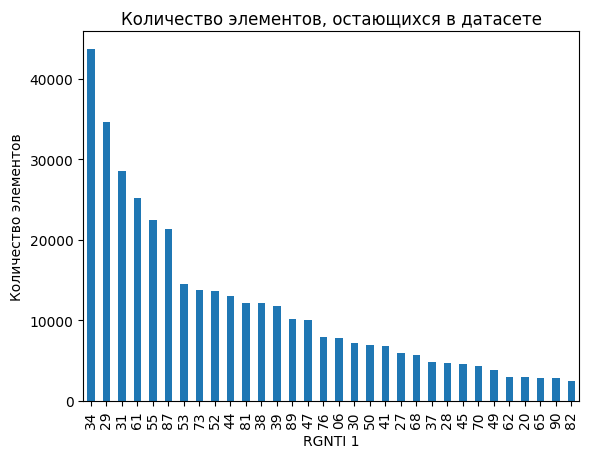

In [9]:
if not os.path.exists(path_info_before_save):
    os.makedirs(path_info_before_save)
df, df_test, n_classes, n_classes2 = get_grnti1_BERT_dataframes("../datasets/base/ru/raw", 
                                            number_of_delteted_values=number_of_delteted_values, 
                                minimal_number_of_elements_RGNTI2=minimal_number_of_elements_RGNTI2,
                                minimal_number_of_words=minimal_number_of_words,
                                dir_name=path_info_before_save, grnti_folder="grnti_dicts_level1_v2/",
                                change_codes=False)

In [10]:
df.shape

(285159, 13)

In [11]:
n_classes

32

In [12]:
df['text'] = df['text'].progress_apply(clear_text)

  0%|          | 0/285159 [00:00<?, ?it/s]

In [13]:
df_test['text'] = df_test['text'].progress_apply(clear_text)

  0%|          | 0/166183 [00:00<?, ?it/s]

In [14]:
import string

# Базовые символы из модуля string
delimiters = set(string.punctuation)
# whitespace_list = list(string.whitespace)
# Дополнительные символы, которые могут быть разделителями
additional_delimiters = {"|", "/", "\\", "-", "_", ".", "*", "+", "=", "&", "%", "$", "#", "@", "!", "?", "~", "^", "(", ")", "[", "]", "{", "}", "<", ">", "'", '"', "`"}

# Объединяем все символы
all_delimiters = delimiters.union(additional_delimiters)

In [15]:
def get_word_parts(input_string, delimiters):
    # 
    word_start = ""
    word_finish = ""

    # Проверяем, есть ли строка из сета слева
    for delim in delimiters:
        if input_string.startswith(delim):
            word_start +=  delim
            input_string = input_string[len(delim):]
        
    # Проверяем, есть ли строка из сета справа

        if input_string.endswith(delim):
            # Если найдено, возвращаем оставшуюся часть строки
            input_string = input_string[:-len(delim)]
            word_finish += delim
        
    return word_start, input_string, word_finish



In [16]:
# !pip3 install pandas jupyter

In [17]:
def aug_for_sokr(text, sokr_kind, data_sokr_dict, delimiters):
    result_text_list = []
    for input_string in text.split(): 
        word_start, input_string, word_finish = get_word_parts(input_string, delimiters)

        # if input_string in data_sokr_dict:
        result_text_list.append(data_sokr_dict[input_string] + " " +
                                word_start + input_string + word_finish
                                if input_string in data_sokr_dict and sokr_kind=="append_sokr"
                                else word_start + data_sokr_dict[input_string] + word_finish
                                if input_string in data_sokr_dict and sokr_kind=="rename_sokr"
                                else word_start + input_string + word_finish
                                )
    return " ".join(result_text_list)


In [18]:

# df_processed = df["text"].progress_apply(aug_for_sokr,
#                           sokr_kind = "append_sokr",
#                           data_sokr_dict = data_sokr_dict,
#                           delimiters=delimiters,
#                           )

In [19]:

# df_processed_v2 = df["text"].progress_apply(aug_for_sokr,
#                           sokr_kind = "rename_sokr",
#                           data_sokr_dict = data_sokr_dict,
#                           delimiters=delimiters,
#                           )

In [20]:
aug_for_sokr("вообще, .ЭЦ, это очень важно",
                          sokr_kind = "rename_sokr",
                          data_sokr_dict = data_sokr_dict,
                          delimiters=delimiters)

'вообще, .электрическая централизация, это очень важно'

In [21]:
compute_metrics = prepair_compute_metrics(n_classes=n_classes)

In [22]:
dir_name = base_name + "model bert lora level 1/"
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

In [23]:
save_parameters(dir_name = dir_name, 
                number_of_delteted_values = number_of_delteted_values, 
                minimal_number_of_elements_RGNTI2= minimal_number_of_elements_RGNTI2,
                minimal_number_of_words = minimal_number_of_words, 
                max_number_tokens= max_number_tokens, 
                pre_trained_model_name= pre_trained_model_name,
                r=r, 
                lora_alpha= lora_alpha, lora_dropout = lora_dropout,
                epoch= epoch, 
                batch_size= batch_size,
                weight_decay= weight_decay,
                warmup_steps= warmup_steps,
                fp16=fp16, 
                optim= optim)

In [24]:
def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
df_old_text = df["text"].copy()
df_test_old_text = df_test["text"].copy()

for sokr_kind in tqdm(["append_sokr"],#"rename_sokr", "no_sokr"
                      leave=True, desc="sokr_kind", total=1):
    

    SEED = 12345
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    


    df['text'] = df_old_text.progress_apply(aug_for_sokr,
                          sokr_kind = sokr_kind,
                          data_sokr_dict = data_sokr_dict,
                          delimiters=delimiters,
                          )
    df_test['text'] = df_test_old_text.progress_apply(aug_for_sokr,
                          sokr_kind = sokr_kind,
                          data_sokr_dict = data_sokr_dict,
                          delimiters=delimiters,
                          )
    
    train_dataset, validation_dataset, test_dataset,\
    tokenizer, collate_fn, class_weights = prepair_datasets(df, df_test,
                                                            n_classes, 
                                                            level = '',
                                                            max_number_tokens=max_number_tokens, 
                                                            pre_trained_model_name=pre_trained_model_name)

    model = prepair_model(n_classes=n_classes, 
                            pre_trained_model_name=pre_trained_model_name,
                            r=r, lora_alpha=lora_alpha, 
                            lora_dropout=lora_dropout)

    dir_name_new = dir_name + sokr_kind + "/"
    if not os.path.exists(dir_name_new):
        os.makedirs(dir_name_new)


    training_args = TrainingArguments(
        output_dir=dir_name_new,          
        num_train_epochs=epoch,
        warmup_steps=warmup_steps,
        logging_dir=dir_name_new,
        weight_decay=weight_decay,
        eval_strategy='epoch',
        save_strategy= "epoch",
        logging_strategy="steps",
        logging_steps = 100,
        load_best_model_at_end=True,
        save_total_limit=1,
        report_to='tensorboard',
        overwrite_output_dir = False,
        save_safetensors = False,
        fp16=fp16,
        optim = optim,
        per_device_train_batch_size= batch_size,
        per_device_eval_batch_size= batch_size,
        group_by_length=True,
        dataloader_num_workers = 4,
        metric_for_best_model="eval_f1_weighted_0.5",
        )
    train_dataset = train_dataset.remove_columns("text")
    validation_dataset = validation_dataset.remove_columns(["text", "__index_level_0__"])

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=validation_dataset,
        data_collator = collate_fn,
        tokenizer = tokenizer,
        compute_metrics=compute_metrics,
        class_weights=class_weights,
    )

    trainer.train()
    trainer.model.save_pretrained(dir_name_new + "bert_peft_level1_lora")

    #______________________________________________________________________
    test_dataset = test_dataset.remove_columns(["text", "__index_level_0__"])

    predict_res = trainer.predict(test_dataset=test_dataset).predictions

    with open(dir_name_new + "trainer_predictions_level1_lora.npy", 'wb') as f:
        np.save(f, predict_res)

    with open(dir_name_new + "trainer_predictions_level1_lora.npy", 'rb') as f:

        prediction1_experiment = np.load(f)

    label_test = np.vstack(df_test["target_coded"])


    if not os.path.exists(path_info_before_save + sokr_kind + "/"):
        os.makedirs(path_info_before_save + sokr_kind + "/")

    test_predictons(sigmoid_array(prediction1_experiment),
                    label_test,
                    path_info_before_save + sokr_kind + "/",
                    n_classes,  
                    level=1,
                    grnti_path="grnti_dicts_level1_v2/")



sokr_kind:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/285159 [00:00<?, ?it/s]

  0%|          | 0/166183 [00:00<?, ?it/s]

Веса для кажого класса:  tensor([1.3164, 1.2443, 1.5663, 0.6472, 3.6027, 0.2040, 3.0185, 1.4897, 3.1646,
        0.8802, 1.2860, 2.2852, 0.4165, 0.3968, 1.1249, 0.3536, 1.9390, 0.7354,
        1.8193, 0.3115, 0.8897, 0.2691, 0.6810, 0.6133, 0.6533, 0.7356, 2.0284,
        0.7524, 1.9058, 3.0932, 1.1319, 3.0083], dtype=torch.float64)
Подготовка тренировочных данных:


Map:   0%|          | 0/228152 [00:00<?, ? examples/s]

Подготовка валидационных данных:


Map:   0%|          | 0/57007 [00:00<?, ? examples/s]

Подготовка тестовых данных:


Map:   0%|          | 0/166183 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

  0%|          | 0/285190 [00:00<?, ?it/s]

c:\Users\victo\git_Work_VINITI_2024\my_venv_cuda\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'loss': 0.4631, 'grad_norm': 0.3444170355796814, 'learning_rate': 4.9984220492320644e-05, 'epoch': 0.0}
{'loss': 0.1458, 'grad_norm': 0.2715265154838562, 'learning_rate': 4.996668770601024e-05, 'epoch': 0.01}
{'loss': 0.1415, 'grad_norm': 0.2934219539165497, 'learning_rate': 4.994915491969984e-05, 'epoch': 0.01}
{'loss': 0.1354, 'grad_norm': 0.37751561403274536, 'learning_rate': 4.9931622133389436e-05, 'epoch': 0.01}
{'loss': 0.1305, 'grad_norm': 0.20893947780132294, 'learning_rate': 4.991408934707904e-05, 'epoch': 0.02}
{'loss': 0.1164, 'grad_norm': 0.40214645862579346, 'learning_rate': 4.989655656076864e-05, 'epoch': 0.02}
{'loss': 0.1054, 'grad_norm': 0.17513519525527954, 'learning_rate': 4.987902377445824e-05, 'epoch': 0.02}
{'loss': 0.1002, 'grad_norm': 0.28804829716682434, 'learning_rate': 4.986149098814784e-05, 'epoch': 0.03}
{'loss': 0.0928, 'grad_norm': 0.32540595531463623, 'learning_rate': 4.984395820183744e-05, 'epoch': 0.03}
{'loss': 0.0952, 'grad_norm': 0.2405790090560913

  0%|          | 0/7126 [00:00<?, ?it/s]

{'eval_loss': 0.03972908854484558, 'eval_accuracy_micro_0.5': 0.9827494025230408, 'eval_accuracy_macro_0.5': 0.982749342918396, 'eval_accuracy_weighted_0.5': 0.9745665192604065, 'eval_f1_micro_0.5': 0.7727525234222412, 'eval_f1_macro_0.5': 0.7371273040771484, 'eval_f1_weighted_0.5': 0.7655503749847412, 'eval_f1_micro_0.6': 0.7568511962890625, 'eval_f1_macro_0.6': 0.715980589389801, 'eval_f1_weighted_0.6': 0.7453075647354126, 'eval_f1_micro_0.7': 0.7257327437400818, 'eval_f1_macro_0.7': 0.6792643070220947, 'eval_f1_weighted_0.7': 0.7085013389587402, 'eval_f1_micro_0.8': 0.6711833477020264, 'eval_f1_macro_0.8': 0.48996055126190186, 'eval_f1_weighted_0.8': 0.5180400609970093, 'eval_f1_micro_0.9': 0.5549047589302063, 'eval_aucroc_micro': 0.9158798456192017, 'eval_aucroc_macro': 0.9036651849746704, 'eval_aucroc_weighted': 0.9133782982826233, 'eval_runtime': 2319.7816, 'eval_samples_per_second': 24.574, 'eval_steps_per_second': 3.072, 'epoch': 1.0}
{'loss': 0.0378, 'grad_norm': 0.27163523435

In [ ]:
# trainer.get_num_trainable_parameters() #615200 без lora